In [1]:
import tensorflow as tf
import numpy as np

INPUT_SIZE = (256, 256)

# Load pretrain models

In [2]:
simple_model = tf.keras.models.load_model("checkpoints/simple_model")

staked_model = tf.keras.models.load_model("checkpoints/stacked_model")

esp32_model = tf.keras.models.load_model("checkpoints/esp32")

2023-04-14 12:14:12.316830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-14 12:14:12.316983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [3]:
tf.keras.utils.plot_model(simple_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [4]:
simple_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 254, 254, 4)       112       
                                                                 
 1st_max_pooling (MaxPooling  (None, 127, 127, 4)      0         
 2D)                                                             
                                                                 
 2nd_conv_3x3 (Conv2D)       (None, 125, 125, 8)       296       
                                                                 
 2nd_max_pooling (MaxPooling  (None, 62, 62, 8)        0         
 2D)                                                             
                                                                 
 3rd_conv_3x3 (Conv2D)       (None, 60, 60, 16)        1168

# Load an image to use as study sample

In [6]:
sample_image_esp = tf.keras.utils.load_img("../datasets/test/dora_stares_at_you.jpg", target_size=(96, 96), color_mode="grayscale")
sample_image_vector_esp = tf.keras.utils.img_to_array(sample_image_esp)

# first we need to add a dimension to our image array to be able to be processed by the model (1, 256, 256, 3)
sample_image_vector_esp = np.expand_dims(sample_image_vector_esp, axis=0).astype("uint8")

In [7]:
sample_image_vector.shape

(1, 256, 256, 3)

# Plot image

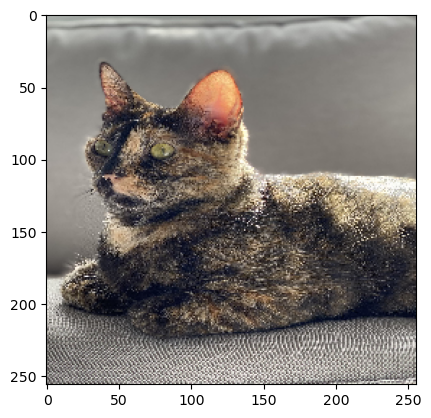

In [8]:
import matplotlib.pyplot as plt

# plt.axis("off")
plt.imshow(sample_image_vector[0])

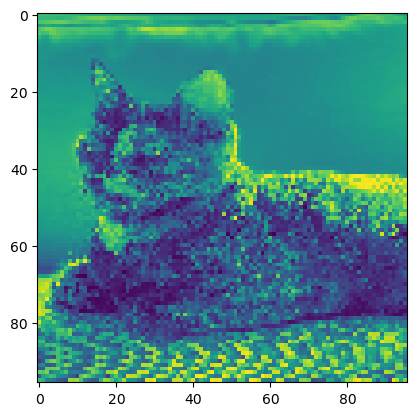

In [9]:
import matplotlib.pyplot as plt

# plt.axis("off")
plt.imshow(sample_image_vector_esp[0])

# To understand how the filters work on the image we are going to apply each of those filters and look at the output they generate

For this we are going to extract all the models outputs from each layer but only those with convolutions or maxpooling

- 1 We can do that by asking the model for his layers and then each layer for their respective outputs
- 2 We can build a new model using the input layer and all the outputs we've collected.

In [10]:
def get_outputs_from_model(model):
    layers_outputs = []
    layers_names = []

    for layer in model.layers:
        if type(layer) == tf.keras.layers.Conv2D or type(layer) == tf.keras.layers.MaxPool2D:
            layers_outputs.append(layer.output)
            layers_names.append(layer.name)
    
    return layers_outputs, layers_names

# Predictions from all models

In [11]:
normalized_sample_image_vector = sample_image_vector/255.0
normalized_sample_image_vector_esp = sample_image_vector_esp/255.0

In [12]:
esp32_model.predict(normalized_sample_image_vector)

2023-04-14 12:14:14.395765: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-14 12:14:14.434652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 265ms/step


array([[0.52504754]], dtype=float32)

In [13]:
simple_model.predict(normalized_sample_image_vector)

1/1 [==============================] - 0s 132ms/step


2023-04-14 12:14:14.726788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.99995875]], dtype=float32)

In [14]:
staked_model.predict(normalized_sample_image_vector)

1/1 [==============================] - 0s 211ms/step


2023-04-14 12:14:14.972061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.9797363]], dtype=float32)

In [15]:
# More samples

In [16]:
images_path = ["../datasets/test/dora_stares_at_you.jpg",
                "../datasets/test/dora-over-armary-wide-far.jpg",
                "../datasets/test/dora-over-armary-far.jpg",
                "../datasets/test/dora-over-armary-close.jpg",
                "../datasets/test/meow.jpg",
                "../datasets/test/not-a-cat-or-dog.jpg",
                "../datasets/test/panda.jpg",
                "../datasets/test/akita.jpeg",
                "../datasets/test/manydogs.jpeg"]

model_name = {esp32_model:"really small model", simple_model:"Non stacked convs model", staked_model:"Stacked convs model"}

for image in images_path:
    sample_image = tf.keras.utils.load_img(image, target_size=INPUT_SIZE)
    sample_image_vector = tf.keras.utils.img_to_array(sample_image)
    sample_image_vector = sample_image_vector/255.0
    # first we need to add a dimension to our image array to be able to be processed by the model (1, 256, 256, 3)
    sample_image_vector = np.expand_dims(sample_image_vector, axis=0).astype("uint8")
    print(f"Image: {image.split('/')[4]}")
    for model in [esp32_model, simple_model, staked_model]:
        print(f"=================model {model_name[model]}====================")
        print(f"prediction proba: {model.predict(sample_image_vector, verbose=0)}")
    print("\n")


Image: dora_stares_at_you.jpg
=================model really small model====================
prediction proba: [[0.36622036]]
=================model Non stacked convs model====================
prediction proba: [[0.68992054]]
=================model Stacked convs model====================


2023-04-14 12:14:15.352716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-14 12:14:15.419849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2023-04-14 12:14:15.557763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


prediction proba: [[0.99751484]]


Image: dora-over-armary-wide-far.jpg
=================model really small model====================
prediction proba: [[0.5132926]]
=================model Non stacked convs model====================
prediction proba: [[0.49782878]]
=================model Stacked convs model====================
prediction proba: [[0.8103008]]


Image: dora-over-armary-far.jpg
=================model really small model====================
prediction proba: [[0.52050775]]
=================model Non stacked convs model====================
prediction proba: [[0.5386739]]
=================model Stacked convs model====================
prediction proba: [[0.52977693]]


Image: dora-over-armary-close.jpg
=================model really small model====================
prediction proba: [[0.52050775]]
=================model Non stacked convs model====================
prediction proba: [[0.5386739]]
=================model Stacked convs model====================
prediction proba: [[0.

# We have 3 models to test

In [17]:
layers_outputs_esp, layers_names_esp = get_outputs_from_model(esp32_model)

layers_outputs_simple, layers_names_simple = get_outputs_from_model(simple_model)

layers_outputs_staked, layers_names_staked = get_outputs_from_model(staked_model)

In [18]:
# by doing this the model will have multiple outputs instead of one last layer with a sigmoid.

model_multioutputs_esp = tf.keras.Model(inputs=esp32_model.input, outputs=layers_outputs_esp, name="esp")

model_multioutputs_simple = tf.keras.Model(inputs=simple_model.input, outputs=layers_outputs_simple, name="simple")

model_multioutputs_staked = tf.keras.Model(inputs=staked_model.input, outputs=layers_outputs_staked, name="staked")

In [19]:
models = [model_multioutputs_esp, model_multioutputs_simple, model_multioutputs_staked]

# As we can see in the summary we only have those convolutions and maxpooling from the model pulled out

In [20]:
for model in models:
    model.summary()

Model: "esp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 1st_conv_3x3 (Conv2D)       (None, 254, 254, 4)       112       
                                                                 
 1st_max_pooling (MaxPooling  (None, 127, 127, 4)      0         
 2D)                                                             
                                                                 
 2nd_conv_3x3 (Conv2D)       (None, 125, 125, 8)       296       
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
Model: "simple"
_________________________________________________________________
 Layer (type)                Output Shape        

# We need to normalize the image values to keep it in range of 0 to 1

In [21]:
normalized_sample_image_vector = sample_image_vector/255.0
normalized_sample_image_vector_esp = sample_image_vector_esp/255.0

In [22]:
activations = model_multioutputs_esp.predict(normalized_sample_image_vector)

1/1 [==============================] - 0s 47ms/step


2023-04-14 12:14:17.641327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Plot the activations of each feature map

# First activation

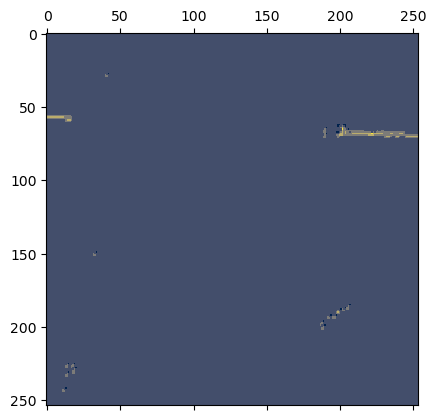

In [23]:
plt.matshow((activations[0][0, :, :, 3]/(1/256)+128).astype("uint8"), cmap="cividis")

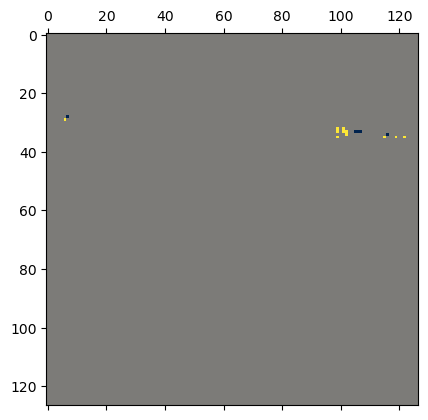

In [24]:
plt.matshow((activations[1][0, :, :, 1]/(1/256)+128).astype("uint8"), cmap="cividis")

# Lets plot of the feature maps from each activation!

In [25]:
def print_activations(model, image_path, layers_names):

    sample_image = tf.keras.utils.load_img(image_path, target_size=INPUT_SIZE)
    sample_image_vector = tf.keras.utils.img_to_array(sample_image)
    normalized_sample_image_vector = sample_image_vector/255.0
    # first we need to add a dimension to our image array to be able to be processed by the model (1, 256, 256, 3)
    sample_image_vector = np.expand_dims(sample_image_vector, axis=0).astype("uint8")

    images_per_row = 4
    
    activations = model.predict(sample_image_vector)

    for layer_name, layer_activation in zip(layers_names, activations):
        n_features = layer_activation.shape[-1]
        # print(f"n_features: {n_features}")
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros(((size+1) * n_cols-1, images_per_row * (size+1)-1))

        for col in range(n_cols):
            for row in range(images_per_row):
                # | col 1  | col 2 | col 3| col 4 | row = 0
                # | col 1| | | | row = 1
                # | col 1| | | | row = 2
                # it moves colum by column of each row
                channel_index = col*images_per_row+row
                channel_image = layer_activation[0, :, :, channel_index].copy()
                # this condition is to not show when the activation is 0
                # This could be because all values are negative and after the apply of the relu they become zero
                if channel_image.sum() != 0:
                    # normalize image
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                # this is to keep it whitin range [0 to 255]
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")

                # this way we end up with feature maps where we have activation
                display_grid[col * (size + 1): (col + 1) * size + col, row*(size+1): (row+1)*size+row] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale*display_grid.shape[0]))

        plt.title(layer_name)
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect="auto", cmap='cividis')

1/1 [==============================] - 0s 39ms/step


2023-04-14 12:14:18.044655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


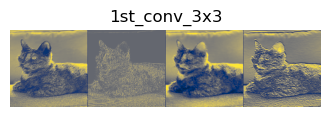

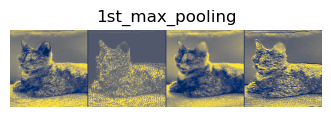

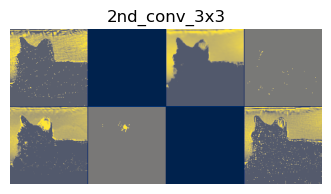

In [26]:
print_activations(model_multioutputs_esp, images_path[0], layers_names_esp)

1/1 [==============================] - 0s 9ms/step


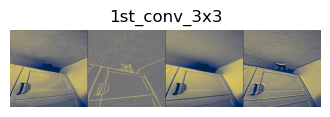

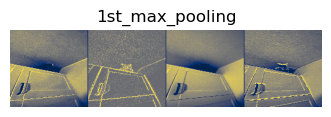

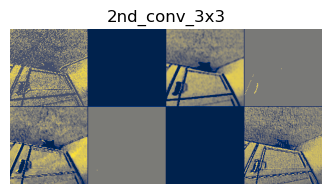

In [27]:
print_activations(model_multioutputs_esp, images_path[1], layers_names_esp)

1/1 [==============================] - 0s 70ms/step


2023-04-14 12:14:18.636027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


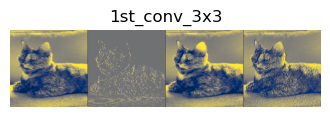

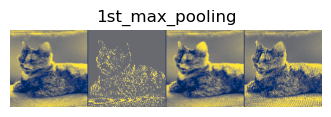

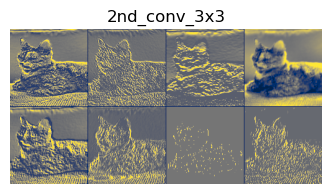

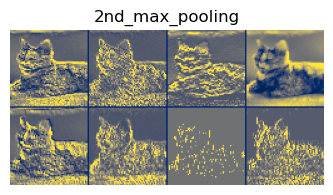

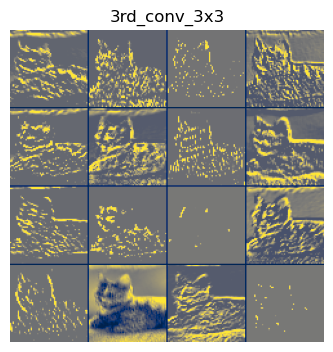

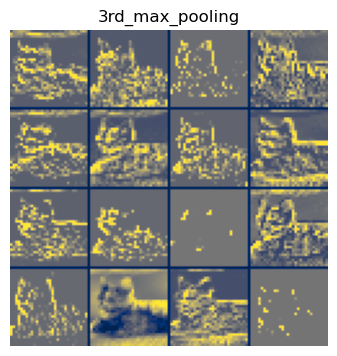

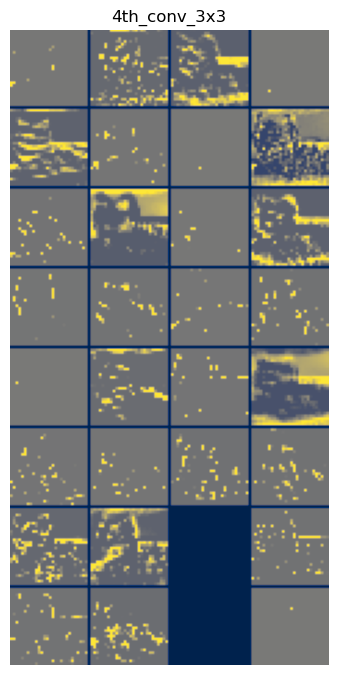

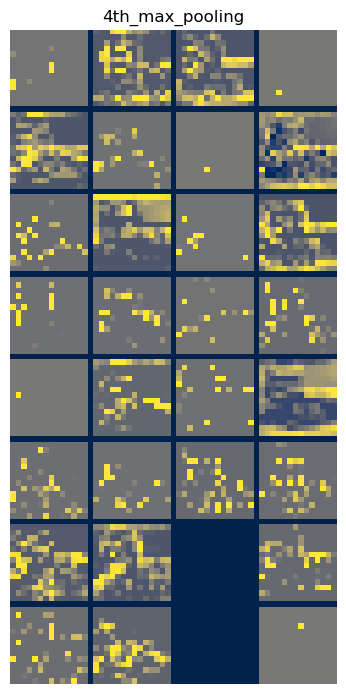

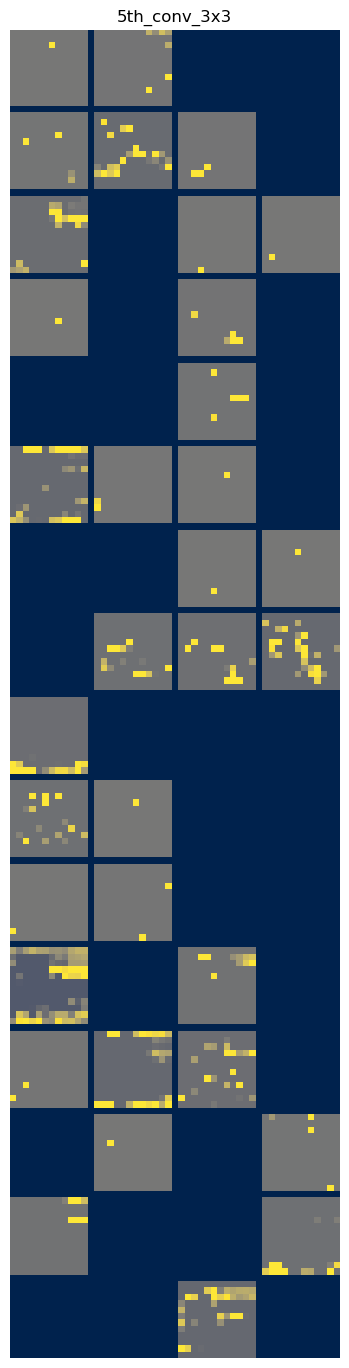

In [28]:
print_activations(model_multioutputs_simple, images_path[0], layers_names_simple)

1/1 [==============================] - 0s 194ms/step


2023-04-14 12:14:19.291055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


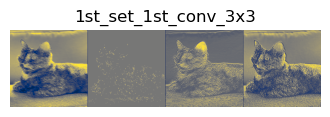

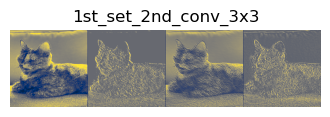

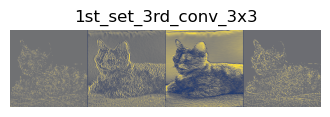

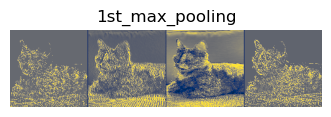

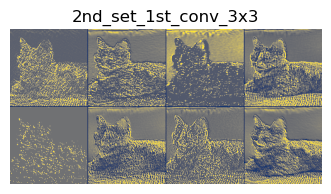

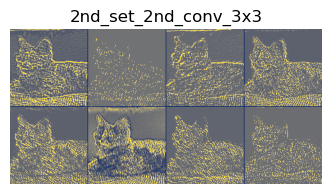

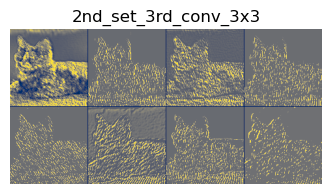

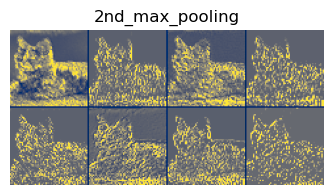

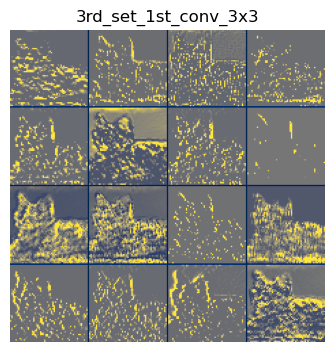

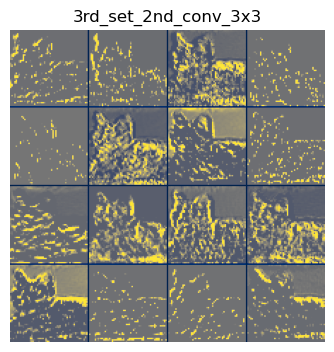

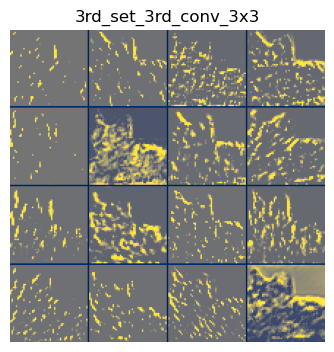

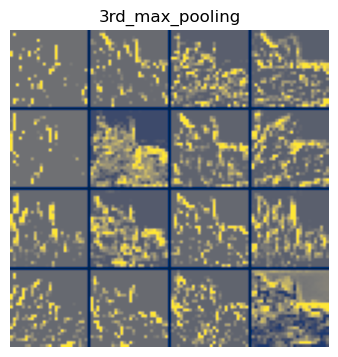

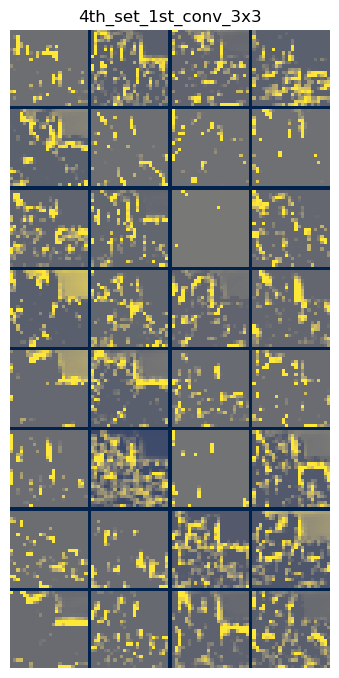

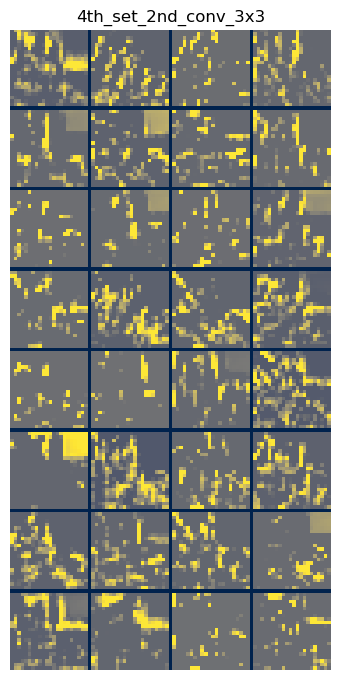

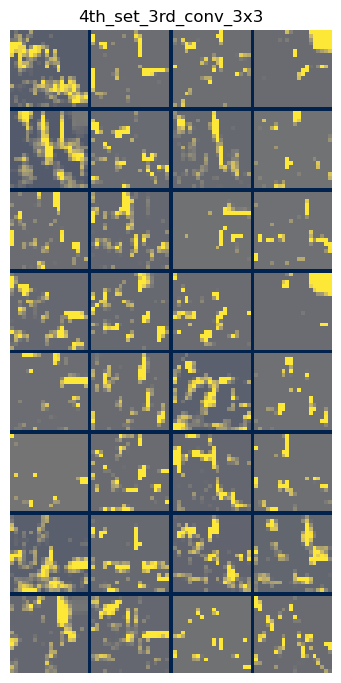

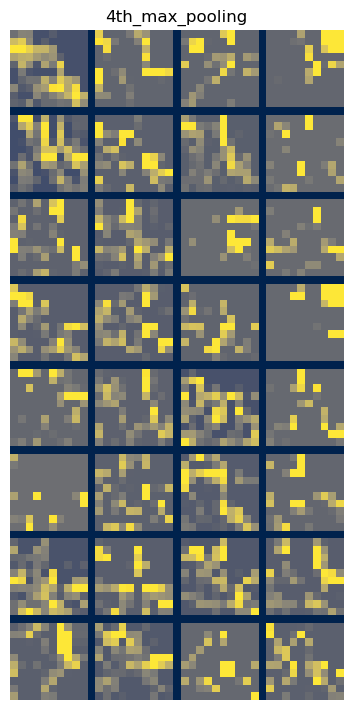

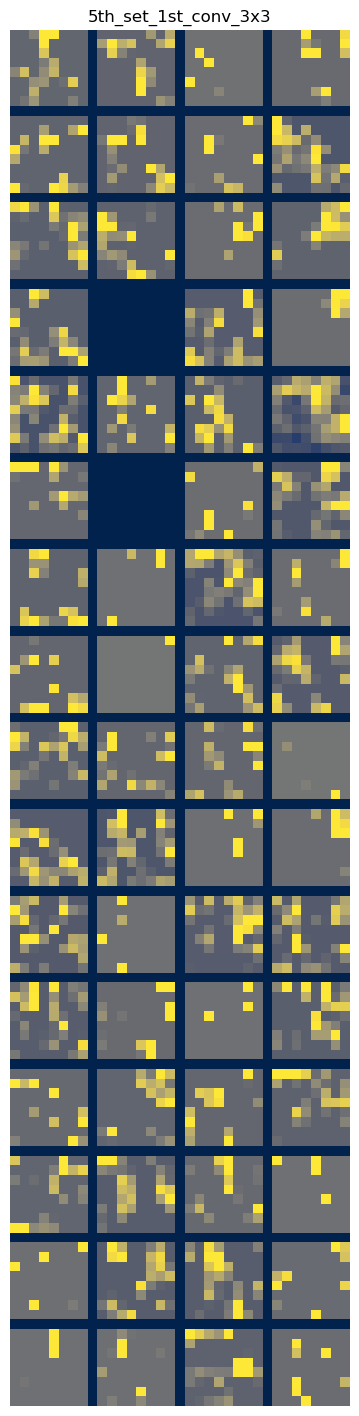

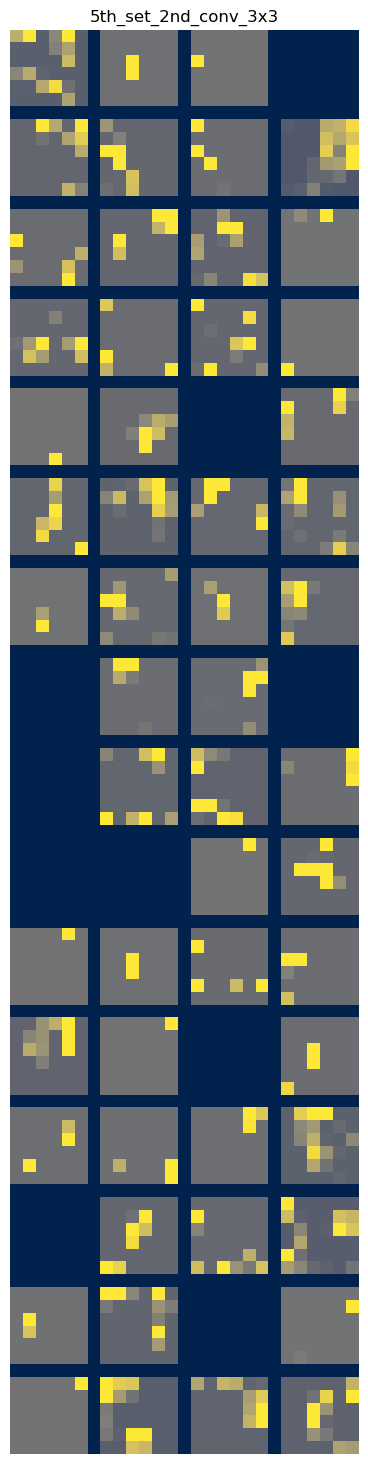

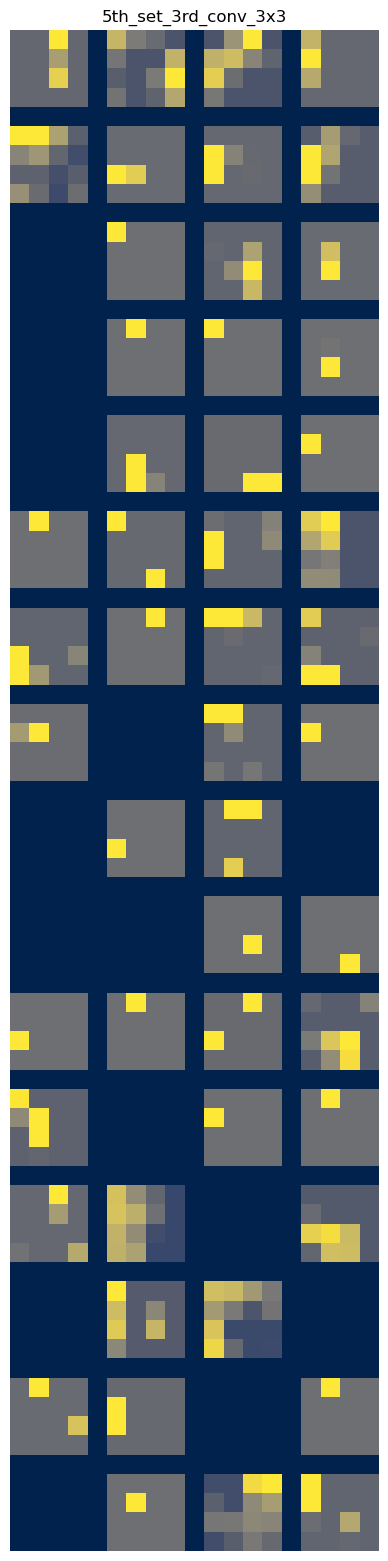

In [29]:
print_activations(model_multioutputs_staked, images_path[0], layers_names_staked)